<h1><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#量化回测框架-PYQBKT" data-toc-modified-id="量化回测框架-PYQBKT-1">量化回测框架 PYQBKT</a></span><ul class="toc-item"><li><span><a href="#回测框架逻辑" data-toc-modified-id="回测框架逻辑-1.1">回测框架逻辑</a></span></li><li><span><a href="#PYQBKT的功能演示---一个简单的动量策略" data-toc-modified-id="PYQBKT的功能演示---一个简单的动量策略-1.2">PYQBKT的功能演示 - 一个简单的动量策略</a></span></li><li><span><a href="#进阶动量策略1：" data-toc-modified-id="进阶动量策略1：-1.3">进阶动量策略1：</a></span></li><li><span><a href="#进阶动量策略2" data-toc-modified-id="进阶动量策略2-1.4">进阶动量策略2</a></span></li><li><span><a href="#三个策略的对比" data-toc-modified-id="三个策略的对比-1.5">三个策略的对比</a></span></li><li><span><a href="#超参数稳定性与过拟合" data-toc-modified-id="超参数稳定性与过拟合-1.6">超参数稳定性与过拟合</a></span></li></ul></li></ul></div>

# 量化回测框架 PYQBKT

PYQBKT是我在实习期间使用python编写的一个简单小程序，用于快速测试一些策略逻辑，假设，或复现研报结果，以及个人投资和理财。

PYQBKT建立在以下几点核心思路：
* 灵活性：可以不断增加新功能，根据具体情况快速自定义新的策略，增加策略研发的效率

* 模块化：PYQBKT由不同模块构成，每个模块之间相互独立，可以根据需求自定义模块的功能

* 简洁性：尽量减少需要手动计算的步骤，最小化运行策略的代码行数

* 辅助功能：可以对比不同策略的结果，并通过过拟合检验考察策略是否存在过拟合的风险

目前支持的回测品种为：股票，指数，基金



## 回测框架逻辑

PYQBKT由以下几个模块组成，每个模块本质上是一个类（class），在实例化产生对象后，通过不同的方法函数计算结果，每个模块之间由一个context的对象传递数据。

总体上结构如下图所示：

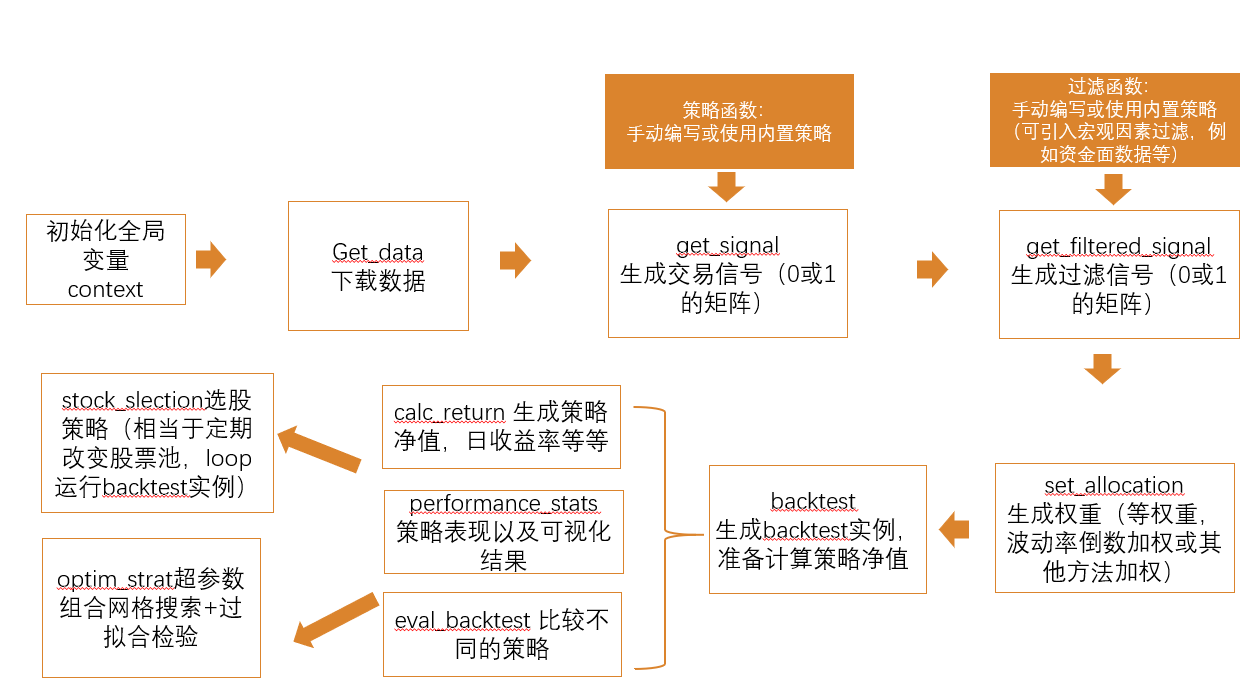

以下代码示范了一个策略回测的6步标准流程：

In [ ]:
# 第一步：初始化context对象，并设定回测的设置变量，如回测时长，初始金额，等等
mycontext = pyqbkt.portfolio() 
mycontext.initial_settings.begin = '2019-01-01' # 回测起始日期
mycontext.initial_settings.end = '2020-12-31' # 回测结束日期
mycontext.initial_settings.fund = 1000000 # 回测金额
mycontext.AssetData.asset_name = list(hs300_const_data.columns) # 证券名称，这里是沪深300成分股
mycontext.AssetData.local_data =hs300_const_data # 附加数据
mycontext.AssetData.market_data = market_data

# 第二步：通过get_data()对象生成数据
gd = pyqbkt.get_data(mycontext)
gd.get_local_data()

# 第三步：通过get_signal()获取策略的交易信号
hyper_param = {'ndays':20,'rank':20} # 策略超参数
gs = pyqbkt.get_signal(mycontext, param=hyper_param)  
gs.run(strategy=pyqbkt.industry_MMT_strat3) # 这里使用了內置的策略 industry_MMT_strat3，也可以手动编写策略函数

# 第四步：通过get_filtered_signal()获取过滤后的交易信号
gfs = pyqbkt.get_filtered_signal(mycontext)
gfs.add_filter(use_filter = False) # 不使用任何过滤器

# 第五步：通过set_allocation()设置资金分配模式
sa = pyqbkt.set_allocation(mycontext,param=60)
sa.get_weight(method='equal') # voll选项为等权重组合，这里使用60天波动率倒数加权

# 第六步：通过backtest()生成策略净值以及可视化图片
bkt= pyqbkt.backtest(mycontext)
bkt.run_backtest(rebalance_freq=30) #使用三十天再平衡 
bkt.calc_return()
bkt.performance_stats(plot_res=True) 

## PYQBKT的功能演示 - 一个简单的动量策略

* 证券池：沪深300成分股

* 时间：2019年1月1日 - 2020年12月31日

* 策略逻辑：设资产Xi过去K日的累计收益率Rt-1,t-k为该资产在t时间的动量(MOMi,t)，每日计算所有沪深300成分股的动量，并按照每支股票的动量由大到小排序，买入排名前N的资产。该策略使用参数ndays = K，rank = N

* 过滤信号逻辑：市场信号，即：如果沪深300指数在t-1日时的收益率低于Z，则在t日平仓

* 权重分配：1/N 或 波动率倒数加权

In [55]:
from WindPy import *
w.start()
import pandas as pd
import numpy as np
from datetime import *
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.path.abspath("D:/PycharmProjects/learnpython/venv/"))
import pyqbktv5 as pyqbkt

In [23]:
# 加载本地数据
myfile_wd = 'C:\\Users\\bianj\\Documents\\python_data\\'

# 沪深300成分股
hs300_const_data = pd.read_csv(myfile_wd+'HS300_constituents_data.csv', index_col=0,encoding='utf-8')
hs300_const_data.index = pd.to_datetime(hs300_const_data.index)

# 沪深300指数
market_data = pd.read_csv(myfile_wd+'HS300_price_daily.csv', index_col=0,encoding='utf-8')
market_data.index = pd.to_datetime(market_data.index)
market_data.columns = ['market_index']

In [32]:
# 初始化mycontext实例，mycontext用于在各个函数之前传递数据
mycontext = pyqbkt.portfolio() 
mycontext.initial_settings.begin = '2019-01-01' # 回测起始日期
mycontext.initial_settings.end = '2020-12-31' # 回测结束日期
mycontext.initial_settings.fund = 1000000 # 回测金额
mycontext.AssetData.asset_name = list(hs300_const_data.columns) # 证券名称，这里是沪深300成分股
mycontext.AssetData.local_data =hs300_const_data # 附加数据
mycontext.AssetData.market_data = market_data
mycontext.initial_settings.trade_fee = 0 # 假设交易成本为0
mycontext.initial_settings.offset=30 # 数据前移30天，给移动技术指标流出空间

In [33]:
 # 处理数据
gd = pyqbkt.get_data(mycontext)
gd.get_local_data()

In [34]:
# 计算动量策略的交易信号；因为策略20天动量排名前20的股票，所以超参数分别为20和20（随便选取）
hyper_param = {'ndays':20,'rank':20}
gs = pyqbkt.get_signal(mycontext, param=hyper_param) 
gs.run(strategy=pyqbkt.industry_MMT_strat3) # 运行策略

In [35]:
# 这里可以添加过滤信号的过滤函数；naive策略暂时不用添加
gfs = pyqbkt.get_filtered_signal(mycontext)
gfs.add_filter(use_filter = False) # 不使用任何过滤器

-------------------------------
* No filter applied to signal *
------------------------------- 



In [36]:
# 资金分配：可以使用等权重或者波动率倒数加权；naive策略暂时使用等权重
sa = pyqbkt.set_allocation(mycontext)
sa.get_weight(method='equal') # equal选项为等权重组合

In [37]:
# 回测净值计算：
bkt_naive= pyqbkt.backtest(mycontext)
bkt_naive.run_backtest(rebalance_freq=None) # 默认再平衡的频率为30天一次，可以修改
bkt_naive.calc_return()

2019-02-20: backtested
2019-04-03: backtested
2019-05-21: backtested
2019-07-03: backtested
2019-08-14: backtested
2019-09-26: backtested
2019-11-14: backtested
2019-12-26: backtested
2020-02-17: backtested
2020-03-30: backtested
2020-05-15: backtested
2020-06-30: backtested
2020-08-11: backtested
2020-09-22: backtested
2020-11-11: backtested
2020-12-23: backtested


<class 'numpy.int64'>
<class 'numpy.int64'>


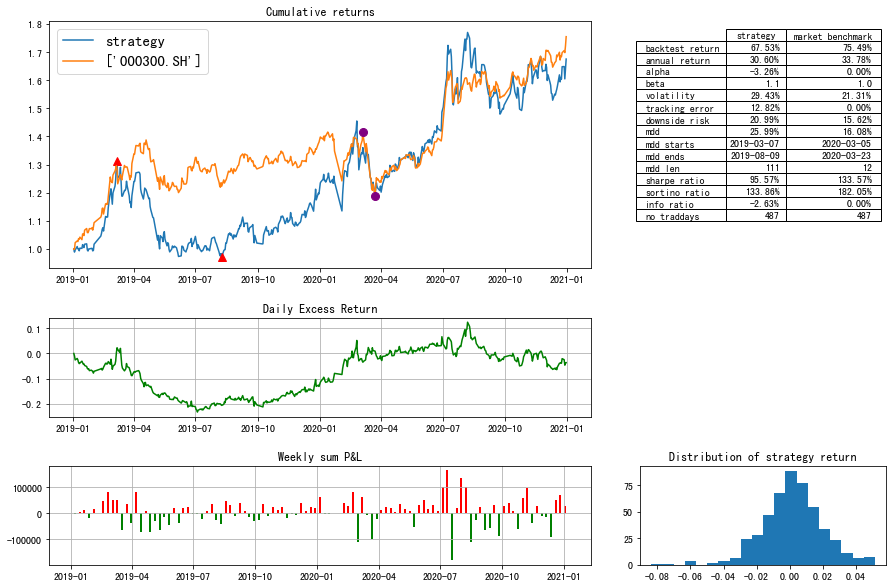

In [38]:
# 绘制回测曲线，并计算风险收益比率
bkt_naive.performance_stats(plot_res=True) 

---

## 进阶动量策略1：
在基础策略上添加市场过滤函数，即：如果沪深300指数在T-1的收益率下行突破规定阈值，即空仓所有组合，持有现金。

不需要从头重新运行策略，只需要从过滤函数的位置更新即可。

In [39]:
gfs = pyqbkt.get_filtered_signal(mycontext)
gfs.add_filter(filter_set=[pyqbkt.mktrt_filter1], # 使用市场指数过滤器
               filter_param={'mktrt_cutoff':-0.01},  # 设定阈值为-1%
               use_filter=True) # 添加过滤器

2018-11-16th date filtered
2018-12-28th date filtered
2019-02-19th date filtered
2019-04-02th date filtered
2019-05-20th date filtered
2019-07-02th date filtered
2019-08-13th date filtered
2019-09-25th date filtered
2019-11-13th date filtered
2019-12-25th date filtered
2020-02-14th date filtered
2020-03-27th date filtered
2020-05-14th date filtered
2020-06-29th date filtered
2020-08-10th date filtered
2020-09-21th date filtered
2020-11-10th date filtered
2020-12-22th date filtered
filters applied
-------------------- 



In [40]:
# 重新计算资金分配

sa = pyqbkt.set_allocation(mycontext)
sa.get_weight(method='equal') # equal选项为等权重组合

In [41]:
# 重新计算回测净值计算：
bkt_with_filter= pyqbkt.backtest(mycontext)
bkt_with_filter.run_backtest(rebalance_freq=None) 
bkt_with_filter.calc_return()

2019-02-20: backtested
2019-04-03: backtested
2019-05-21: backtested
2019-07-03: backtested
2019-08-14: backtested
2019-09-26: backtested
2019-11-14: backtested
2019-12-26: backtested
2020-02-17: backtested
2020-03-30: backtested
2020-05-15: backtested
2020-06-30: backtested
2020-08-11: backtested
2020-09-22: backtested
2020-11-11: backtested
2020-12-23: backtested


<class 'numpy.int64'>
<class 'numpy.int64'>


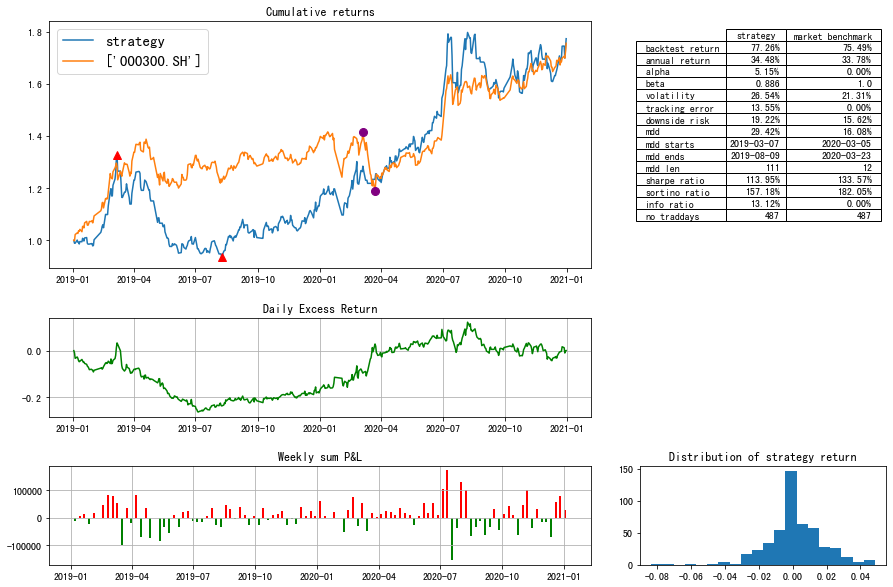

In [42]:
# 绘制回测曲线，并计算风险收益比率
bkt_with_filter.performance_stats(plot_res=True) 

---

## 进阶动量策略2

在进阶版动量策略1的基础上，采用波动率倒数加权，采用20天滚动波动率

回测时只需重新运行权重函数set_allocation与回测函数backtest即可，无需修改之前的函数

In [43]:
sa = pyqbkt.set_allocation(mycontext)
sa.get_weight(method='vol',param=20) # vol选项为等权重组合，param为参数，这里是20天

In [44]:
# 重新计算回测净值计算：
bkt_with_filter_vol= pyqbkt.backtest(mycontext)
bkt_with_filter_vol.run_backtest(rebalance_freq=None) # 默认再平衡的频率为30天一次，可以修改
bkt_with_filter_vol.calc_return()

2019-02-20: backtested
2019-04-03: backtested
2019-05-21: backtested
2019-07-03: backtested
2019-08-14: backtested
2019-09-26: backtested
2019-11-14: backtested
2019-12-26: backtested
2020-02-17: backtested
2020-03-30: backtested
2020-05-15: backtested
2020-06-30: backtested
2020-08-11: backtested
2020-09-22: backtested
2020-11-11: backtested
2020-12-23: backtested


<class 'numpy.int64'>
<class 'numpy.int64'>


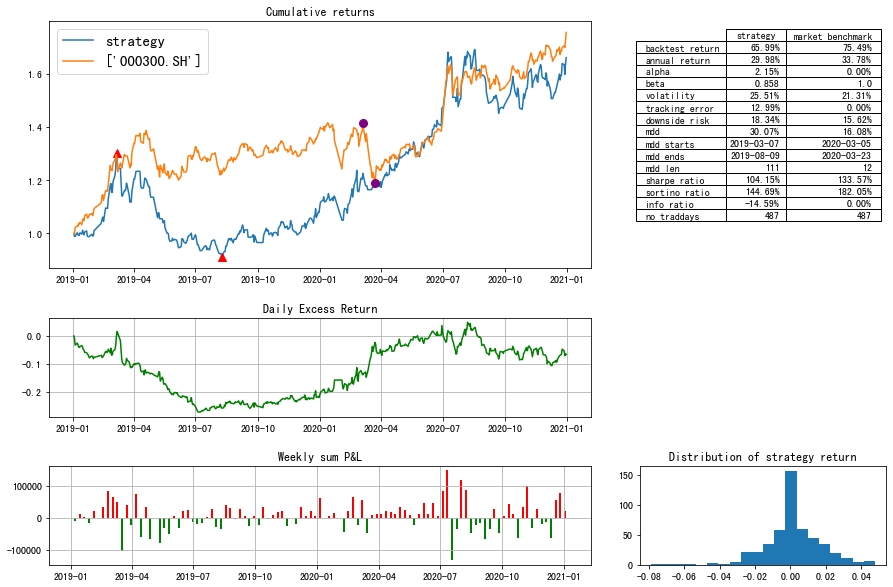

In [45]:
# 绘制回测曲线，并计算风险收益比率
bkt_with_filter_vol.performance_stats(plot_res=True) 

---

## 三个策略的对比
PYQBKT可以对比多种策略的净值及其收益表现

这里，使用eval_backtest函数对比基础动量策略，进阶动量策略1，进阶动量策略2的表现。基准指数为浅灰色

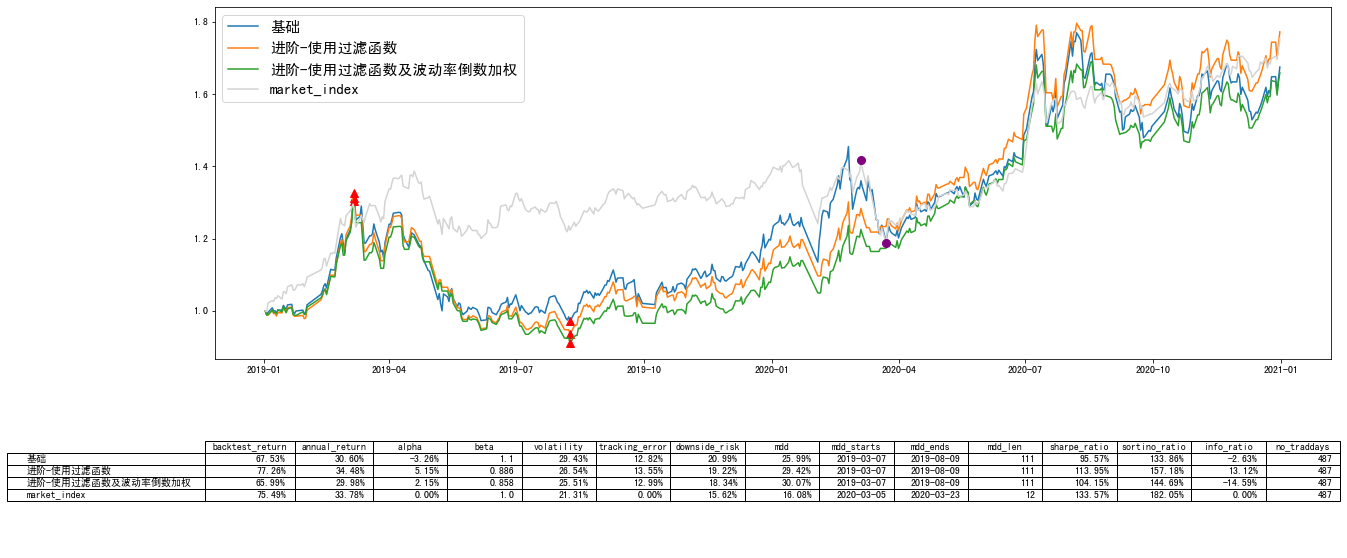

,基础,进阶-使用过滤函数,进阶-使用过滤函数及波动率倒数加权,market_index
backtest_return,67.53%,77.26%,65.99%,75.49%
annual_return,30.60%,34.48%,29.98%,33.78%
alpha,-3.26%,5.15%,2.15%,0.00%
beta,1.1,0.886,0.858,1.0
volatility,29.43%,26.54%,25.51%,21.31%
tracking_error,12.82%,13.55%,12.99%,0.00%
downside_risk,20.99%,19.22%,18.34%,15.62%
mdd,25.99%,29.42%,30.07%,16.08%
mdd_starts,2019-03-07,2019-03-07,2019-03-07,2020-03-05
mdd_ends,2019-08-09,2019-08-09,2019-08-09,2020-03-23


In [46]:
eb = pyqbkt.eval_backtest() # 实例化eval_backtest

eb.compare(backtests=[bkt_naive,bkt_with_filter,bkt_with_filter_vol], # 三个策略的backtest实例
           name_list=['基础','进阶-使用过滤函数','进阶-使用过滤函数及波动率倒数加权']) # 赋予每个策略名称，方便对比
# 

通过对比，可以注意到以下几点：

* 从alpha（年化）上来看，进阶动量策略2的alpha最大，其次为进阶动量策略2，最后为基础策略，其alpha为负数

* 从波动率（年化）上来看，基准策略的波动率最高，其次为进阶动量策略1，最后为进阶动量策略2；过滤函数与波动率倒数加权可以有效削减波动率。

* 与市场指数对比来看，三个策略的最大回测（即mdd，分别为25.99%，29.42%，30.07%），均大于市场指数的最大回测

* 从回测上来看，在三个策略中，基础策略的年化收益最高，但回测也最大；进阶动量策略2（使用过滤函数及波动率倒数加权的策略）的最大回测是三者中最低的，其数值为17%，说明波动率倒数加权可以有效削减回测的幅度。

* 简单的策略并不一定能在短时间内击败市场指数（获得alpha）...

--- 

## 超参数稳定性与过拟合

在使用基于技术指标的策略时，经常需要确定策略的超参数，例如MA策略的快线天数与慢线天数，或者本动量策略的动量天数与持股数量等。由于这些超参数本身不是由数据决定的，因此有可能导致策略在回测期间过拟合，但一上实盘后就表现平平。

PYQBKT可以简单地测试一个策略是否存在过拟合现象。首先，使用网格搜索获得几种超参数组合的回测净值；其次使用CSCV方法计算样本内最佳策略在样本外的表现（例如通过夏普比率策略测量）；最后，计算样本内最佳策略的表现衰减（performance degregation）以及样本外夏普率衰减情况。

这里，我们可以检测上文所采用的动量策略过拟合现象是否严重。

In [49]:
 # 通过参数网格生成不同超参数组合
# 这里分别使用 5天，15天，35天的动量，以及排名前7, 14， 22的证券
mygrid = {'ndays':[5,10 ,20], 'rank':[7, 25, 40]}

-------------------------------
* No filter applied to signal *
------------------------------- 

2019-02-20: backtested
2019-04-03: backtested
2019-05-21: backtested
2019-07-03: backtested
2019-08-14: backtested
2019-09-26: backtested
2019-11-14: backtested
2019-12-26: backtested
2020-02-17: backtested
2020-03-30: backtested
2020-05-15: backtested
2020-06-30: backtested
2020-08-11: backtested
2020-09-22: backtested
2020-11-11: backtested
2020-12-23: backtested
<class 'numpy.int64'>
<class 'numpy.int64'>
Iter 0 completed for paramset {'ndays': 5, 'rank': 7}
-------------------------------
* No filter applied to signal *
------------------------------- 

2019-02-20: backtested
2019-04-03: backtested
2019-05-21: backtested
2019-07-03: backtested
2019-08-14: backtested
2019-09-26: backtested
2019-11-14: backtested
2019-12-26: backtested
2020-02-17: backtested
2020-03-30: backtested
2020-05-15: backtested
2020-06-30: backtested
2020-08-11: backtested
2020-09-22: backtested
2020-11-11: back

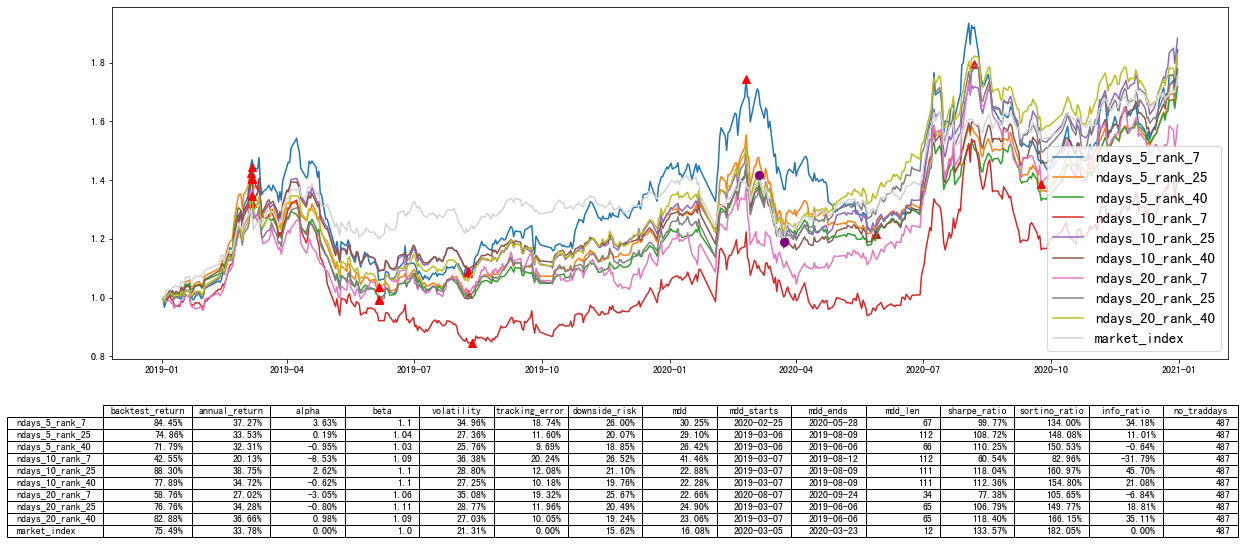

,ndays_5_rank_7,ndays_5_rank_25,ndays_5_rank_40,ndays_10_rank_7,ndays_10_rank_25,ndays_10_rank_40,ndays_20_rank_7,ndays_20_rank_25,ndays_20_rank_40,market_index
backtest_return,84.45%,74.86%,71.79%,42.55%,88.30%,77.89%,58.76%,76.76%,82.88%,75.49%
annual_return,37.27%,33.53%,32.31%,20.13%,38.75%,34.72%,27.02%,34.28%,36.66%,33.78%
alpha,3.63%,0.19%,-0.95%,-8.53%,2.62%,-0.62%,-3.05%,-0.80%,0.98%,0.00%
beta,1.1,1.04,1.03,1.09,1.1,1.1,1.06,1.11,1.09,1.0
volatility,34.96%,27.36%,25.76%,36.38%,28.80%,27.25%,35.08%,28.77%,27.03%,21.31%
tracking_error,18.74%,11.60%,9.69%,20.24%,12.08%,10.18%,19.32%,11.96%,10.05%,0.00%
downside_risk,26.00%,20.07%,18.85%,26.52%,21.10%,19.76%,25.67%,20.49%,19.24%,15.62%
mdd,30.25%,29.10%,26.42%,41.46%,22.88%,22.28%,22.66%,24.90%,23.06%,16.08%
mdd_starts,2020-02-25,2019-03-06,2019-03-06,2019-03-07,2019-03-07,2019-03-07,2020-08-07,2019-03-07,2019-03-07,2020-03-05
mdd_ends,2020-05-28,2019-08-09,2019-06-06,2019-08-12,2019-08-09,2019-08-09,2020-09-24,2019-06-06,2019-06-06,2020-03-23


In [50]:
# 首先，配置mycontext：
mycontext = pyqbkt.portfolio()
mycontext.initial_settings.begin = '2019-01-01'
mycontext.initial_settings.end = '2020-12-31'
mycontext.initial_settings.fund = 1000000
mycontext.AssetData.asset_name = list(hs300_const_data.columns)
mycontext.AssetData.local_data =hs300_const_data
mycontext.AssetData.market_data = market_data
mycontext.initial_settings.trade_fee = 0
mycontext.initial_settings.offset=30

gd = pyqbkt.get_data(mycontext)
gd.get_local_data()

# 初始化实例，并检验上面动量策略
optim = pyqbkt.optim_strat(context=mycontext,
                           strategy=pyqbkt.industry_MMT_strat3,
                           param_grid=mygrid)

# 生成不同策略组合（需要运行一段时间）
optim.search(plot_res = True)

从网格搜索回测的结果看来，在ndays = 5 以及 rank = 7时，动量组合似乎表现的最好，如果我们在回测期间使用这个策略，即可获得alpha等于3.63%的收益，超过其他参数组合的策略

但是，样本内表现最优的组合，在样本外表现不一定最优，甚至有可能会变差！


接下来，通过Bailey、Borwein、López de Prado等人提出的CSCV（Combinatorially-Symmetric Cross-Validation，组合对称交叉验证）框架考察策略的过拟合程度。CSCV的核心逻辑为：将一个收益率矩阵按时间顺序分割成训练集和测试集；首先计算训练集中表现最好（即夏普率最高）的超参数组合，然后计算其在测试集的夏普率，并计算夏普率的变化程度。

如果一个策略存在过拟合，那么其训练集最优参数的表现必定会在测试集中下降很多。

C:\Users\bianj\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\bianj\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


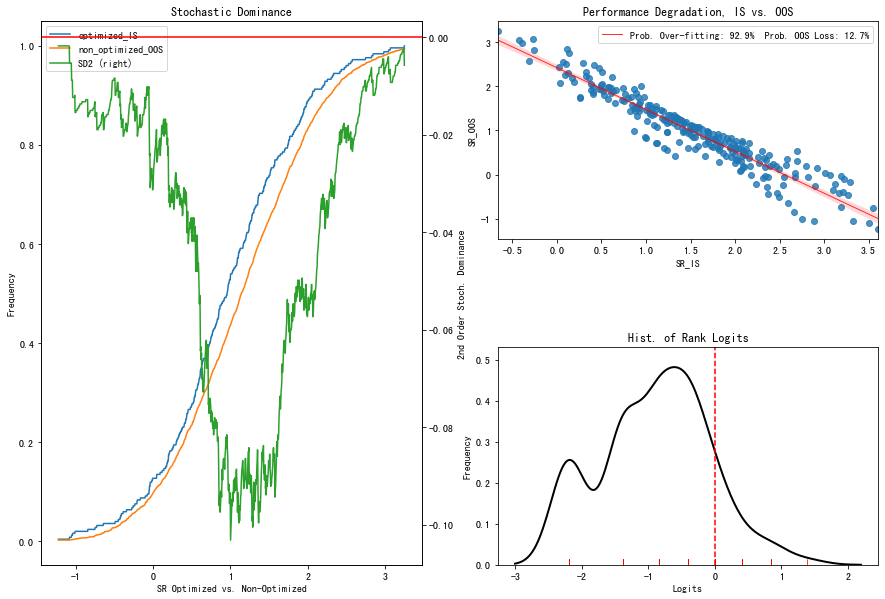

In [61]:
# 运行CSCV，将收益矩阵分割为10块
# 使用的指标是夏普比率
optim.CSCV(n_partition=10,metric_func=pyqbkt.sharpe_iid)

左侧大图展现了样本内最优参数组合与平均参数组合（即全部超参数组合的平均表现）的一阶随机占优与二阶随机占优。如果策略过拟合较为严重，则样本内最优参数组合（蓝色曲线）会出现在平均参数组合（橘色曲线）的右边，即样本内最优参数组合并不一阶随机占优平均参数组合。绿色曲线代表样本内最优参数组合对平均参数组合的二阶随机占优；如果策略过拟合严重，则二阶随机占优会大部分为负值，如上图所示。

右上小图计算了过拟合的概率Prob. Over-fitting为92.9%，说明这里使用的动量策略存在严重的过拟合情况，样本内最优参数在样本外的表现衰退严重，因此可见样本内最优参数组合的夏普率于其在测试集上的夏普率存在明显的负相关。同时，样本外夏普率为负的概率Prob. OOS loss并不是很高，为12.7%，也就是样本外还是很大可能获得正的夏普率。

右下小图为经过逻辑函数变换的夏普率衰退指数logits，如果夏普率衰退的越高，logits的值越负。可以看到，logits的直方图有很大部分都在负值，因此说明策略的过拟合较为严重。